In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import trackbact as tb

# Load the data

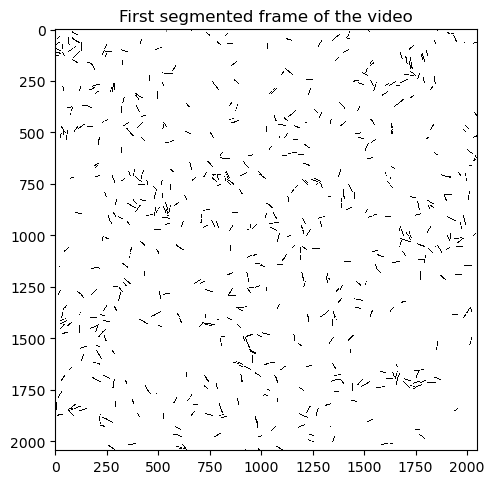

2044 2048


In [4]:
file_name="pilH_dilute_segmented.tif"
im=tb.load_tif(file_name, show=True)
tifdim1=im.shape[1]
tifdim2=im.shape[2]
print(tifdim1, tifdim2)

# Fit ellipses to the contours

Finding the contours of the bacteria...: 100%|██████████████████████████████████████| 241/241 [00:01<00:00, 141.16it/s]


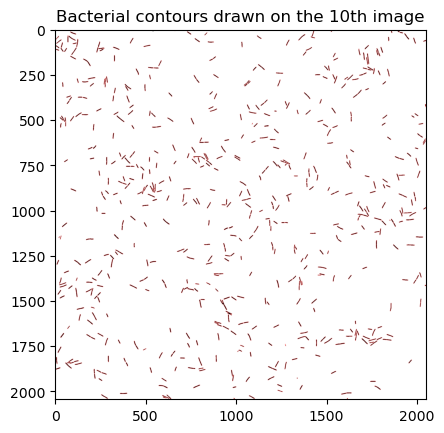

Fitting ellipses to the contours...: 100%|██████████████████████████████████████████| 241/241 [00:01<00:00, 175.90it/s]


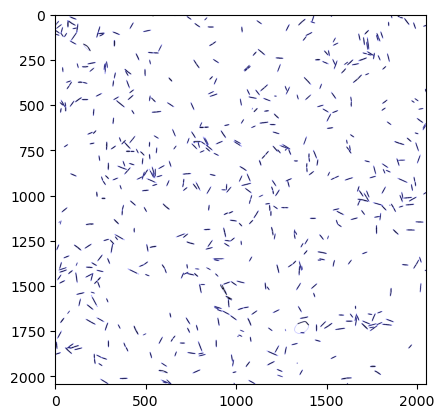

In [5]:
fitted_ellipses=tb.fit_ellipses(im, show_nth_frame=10, filter_max=(8,60))

# Format the data and plot the distribution of alignment angles

,x,y,frame,major_axis_size,minor_axis_size,body_angle
0,922.447632,2040.993896,0,6.335873,3.102256,125.772354
1,988.348450,2039.280273,0,15.296427,4.115221,139.704742
2,604.169983,2034.773193,0,20.112776,3.568538,101.115143
3,1088.163940,2033.127686,0,40.736771,4.462940,118.329773
4,608.044861,2030.621338,0,45.339333,4.577644,105.584564
...,...,...,...,...,...,...
136655,1734.592896,21.615288,240,31.771103,5.834028,179.647797
136656,118.732414,6.221175,240,21.182425,4.305619,120.974945
136657,1908.673828,5.702821,240,16.720350,3.921356,21.642391
136658,1377.943726,0.198957,240,12.498411,3.770381,85.605019


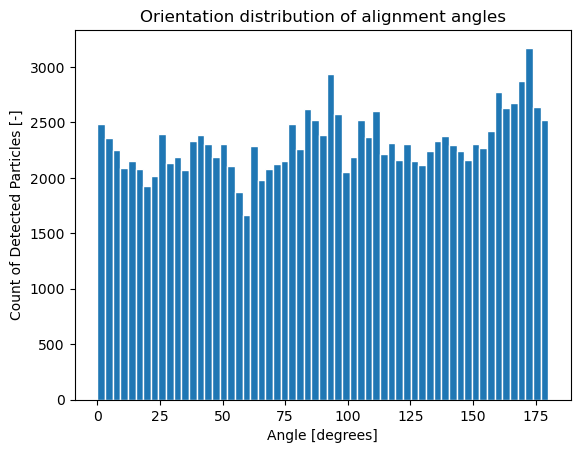

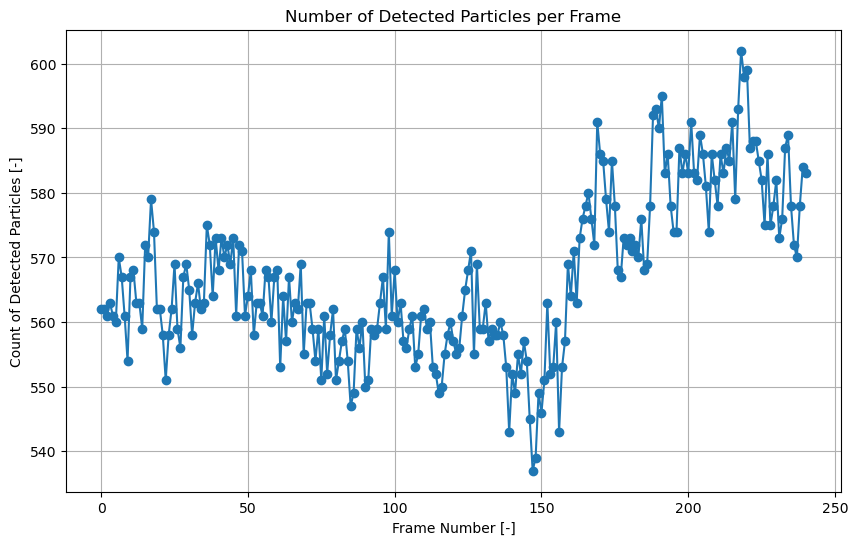

In [11]:
#format the fitted ellipses into a dataframe for tracking
ellipses_df=tb.format_ellipses(fitted_ellipses)
display(ellipses_df)

#For PIV analysis: Uncomment below to transform ellipses into single points
#tb.ellipse_to_particle(im, file_name, ellipses_df)


plt.hist(ellipses_df["body_angle"], bins=59, histtype='bar', ec='white')
plt.title("Orientation distribution of alignment angles")
plt.xlabel('Angle [degrees]')
plt.ylabel('Count of Detected Particles [-]')
plt.show()

# Count the number of particles per frame
particles_per_frame = ellipses_df.groupby('frame').size()

# Plotting
plt.figure(figsize=(10,6))
plt.plot(particles_per_frame.index, particles_per_frame.values, marker='o')  # Use plt.bar for a bar chart
plt.title('Number of Detected Particles per Frame')
plt.xlabel('Frame Number [-]')
plt.ylabel('Count of Detected Particles [-]')
plt.grid(True)
plt.show()

In [12]:
import trackpy.diag
trackpy.diag.performance_report()

Yes, but could it be faster?
FAST: numba is available and enabled (fast subnets and feature-finding).


# Track the bacteria and write the results to disk

In [13]:
traj_tp = tb.track_bacteria(ellipses_df, max_search_range=10, min_search_range=2, filter=75)
display(traj_tp)
tb.write_trajectory(traj_tp, file_name)

Frame 240: 583 trajectories present.


,particle,count
0,474,241
1,136,241
2,116,241
3,213,241
4,437,241
...,...,...
576,4352,76
577,4356,76
578,2827,76
579,4359,76


,x,y,frame,major_axis_size,minor_axis_size,body_angle,particle
0,658.330444,664.403687,0,44.949986,4.463994,163.776703,1
1,657.946594,663.844116,1,44.310726,4.373544,164.760803,1
2,657.810913,663.562866,2,43.523331,4.595137,165.294479,1
3,657.126282,661.939087,3,43.956234,4.356061,165.392853,1
4,656.563721,660.752075,4,43.976242,4.618662,167.563828,1
...,...,...,...,...,...,...,...
96308,1985.338623,897.991394,236,54.302467,4.579717,151.911362,4359
96309,1984.857544,896.172180,237,57.275627,4.676484,151.067429,4359
96310,1983.416382,894.472412,238,52.777596,4.810871,153.110931,4359
96311,1982.234009,892.342041,239,51.359745,4.757159,152.708969,4359


# Load the results of the tracking

In [14]:
traj_loaded=tb.read_trajectory(file_name)
display(traj_loaded)

,x,y,frame,major_axis_size,minor_axis_size,body_angle,particle
0,658.330444,664.403687,0,44.949986,4.463994,163.776703,1
1,657.946594,663.844116,1,44.310726,4.373544,164.760803,1
2,657.810913,663.562866,2,43.523331,4.595137,165.294479,1
3,657.126282,661.939087,3,43.956234,4.356061,165.392853,1
4,656.563721,660.752075,4,43.976242,4.618662,167.563828,1
...,...,...,...,...,...,...,...
96308,1985.338623,897.991394,236,54.302467,4.579717,151.911362,4359
96309,1984.857544,896.172180,237,57.275627,4.676484,151.067429,4359
96310,1983.416382,894.472412,238,52.777596,4.810871,153.110931,4359
96311,1982.234009,892.342041,239,51.359745,4.757159,152.708969,4359


# Plot trajectories

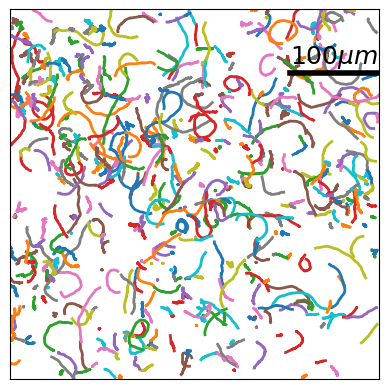

In [15]:
tb.plot_traj_all(traj_loaded, imdim1=tifdim1, imdim2=tifdim2, pix_size=0.1615)

# Calculate the kinematic parameters such as velocity and acceleration etc.

In [9]:
particle_params=tb.calculate_kinematic_parameters(traj_tp, time_step=1)
display(particle_params)

100%|██████████| 357/357 [00:00<00:00, 399.57it/s]


,x,y,frame,major_axis_size,minor_axis_size,body_angle,particle,vx,vy,vel,ax,ay,acc,angle,angular_vel,angular_acc
0,1840.333862,858.746216,0,32.272427,6.306262,53.048576,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1839.520874,859.246155,1,31.828880,6.473937,54.441719,13,-0.812988,0.499939,0.954405,NaN,NaN,NaN,2.590260,NaN,NaN
2,1837.850708,861.069641,2,31.478331,6.143157,54.098339,13,-1.670166,1.823486,2.472763,-0.857178,1.323547,1.576874,2.312337,-0.277923,NaN
3,1836.064209,862.935974,3,33.203121,5.944539,54.068077,13,-1.786499,1.866333,2.583559,-0.116333,0.042847,0.123973,2.334343,0.022005,0.299928
4,1837.799683,862.851807,4,33.616631,6.312464,54.580780,13,1.735474,-0.084167,1.737513,3.521973,-1.950500,4.026008,-0.048460,-2.382803,-2.404808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48830,112.296646,2052.912598,195,25.169781,4.609334,75.796524,1652,1.007965,0.709229,1.232477,4.235161,-1.197998,4.401339,0.613154,-1.994674,-2.017565
48831,112.542496,2052.496582,196,26.809267,5.211643,75.939171,1652,0.245850,-0.416016,0.483230,-0.762115,-1.125244,1.359042,-1.037049,-1.650203,0.344471
48832,109.164726,2053.895752,197,23.478580,4.563632,72.498573,1652,-3.377769,1.399170,3.656091,-3.623619,1.815186,4.052840,2.748880,3.785929,5.436132
48833,104.880051,2055.917969,198,24.162683,4.245761,75.040085,1652,-4.284676,2.022217,4.737912,-0.906906,0.623047,1.100303,2.700624,-0.048257,-3.834186
